In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!tar xvzf drive/'My Drive'/csvs.tar
!tar xvzf drive/'My Drive'/txt.tar
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

# Plotting Dependencies
from sklearn import datasets
import matplotlib.pyplot as plt

# Preprocessing dependencies
import csv
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
#!ls

embedded_data.csv
embedded_data_training.csv
sample_submission.csv
train.csv
ID.txt
ID_training.txt
ID_tuned.txt


In [0]:
import csv
import numpy as np 
x = []
with open('embedded_data_training.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ' ')
  for row in reader:
    x.append([float(n) for n in row])

training = np.asarray(x)

x = []
with open('embedded_data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ' ')
  for row in reader:
    x.append([float(n) for n in row])
test = np.asarray(x)

In [0]:
 def PCA_iterative(data, threshold, mode = 'threshold', whiten_bool = 'False', n = 0):
   """
   mode = 'components' does PCA reduction to n components
   mode = 'threshold' performs PCA reduction to the fewest components that satisfy a threshold of explained variance
   prints out how many components the data was reduced to
   prints out 
   """
   if mode == 'threshold':
     for i in range(2, data.shape[1]+1):
       pca = PCA(n_components = i, whiten=whiten_bool)
       B = pca.fit_transform(data)
       L = pca.explained_variance_
       cl=np.cumsum(L); 
       if (cl[i-2]/cl[-1]) > threshold:
         break
   else:
     pca = PCA(n_components = n, whiten=whiten_bool)
     B = pca.fit_transform(data) 
     L = pca.explained_variance_
     cl=np.cumsum(L); 
     print('PCA reduction to ', n, ' components with', cl[i-2]/cl[-1], ' explained variance')
 
   # PCA scree plot
   plt.subplot(111); 
   plt.ylabel('Total Variance');
   plt.xlabel('Principal component')
   plt.plot(np.arange(1,L.shape[0]+1),cl/cl[-1],'o-r'); 
   plt.ylim(0,None);
   return B, pca

In [0]:
train_labels = pd.read_csv("train.csv")
train_ids = pd.read_csv("ID_training.txt", header=None, names=['image_id'])
test_ids = pd.read_csv("ID.txt", header=None, names=['image_id'])

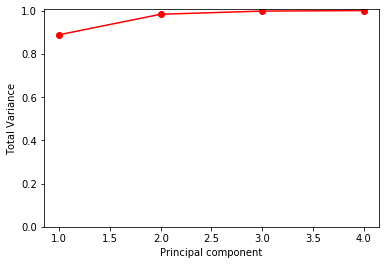

In [8]:
data, pca = PCA_iterative(training, 0.99, mode = 'threshold')
gmm = GaussianMixture(n_components=3, n_init=10).fit(data)

In [9]:
sample = pca.transform(test)
sample_scores = sample @ gmm.means_.T
data_scores = data @ gmm.means_.T
data_scores

array([[-0.69768901, -1.29348154,  2.35216378],
       [ 1.13710815, -1.3480418 ,  1.29554647],
       [-0.81845363, -0.86048202,  1.78444569],
       ...,
       [ 1.42867331,  0.03349237, -0.93549213],
       [ 1.67619919, -0.98582606,  0.42375979],
       [-1.75084657, -1.06581782,  2.66726469]])

In [0]:
train_data = []
labels = []
for i, row in train_labels.iterrows():
  batches = [float(x) for x in row["PredictionString"].split()]
  for j, _ in enumerate(batches[::7]):
    result = np.array(batches[j*7:j*7 + 7])[1:]
    train_data.append(data_scores[train_ids.image_id == f"crop_{row.ImageId}_{j}.jpg"])
    labels.append(result)


In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset

x = torch.from_numpy(np.array(train_data)).float()
y = torch.from_numpy(np.array(labels)).float()
dataset = TensorDataset(x, y)

train_loader = DataLoader(dataset=dataset, batch_size=1024, shuffle=True)

In [12]:
from torch.autograd import Variable
import torch



print(x, y)

tensor([[[-1.3333, -0.7872,  1.9949]],

        [[-1.2017, -0.6583,  1.7220]],

        [[ 0.1360, -0.2334,  0.2621]],

        ...,

        [[ 1.7549, -1.0552,  0.4780]],

        [[-1.8307,  1.6346, -1.2908]],

        [[-0.1638,  0.7943, -1.0773]]]) tensor([[ 2.5484e-01, -2.5753e+00, -3.1026e+00,  7.9654e+00,  3.2007e+00,
          1.1023e+01],
        [ 1.8165e-01, -1.4695e+00, -3.1216e+00,  9.6033e+00,  4.6663e+00,
          1.9339e+01],
        [ 1.6307e-01, -1.5687e+00, -3.1175e+00,  1.0390e+01,  1.1222e+01,
          5.9783e+01],
        ...,
        [ 1.4320e-01,  3.0294e+00, -3.1307e+00, -3.2069e+01,  1.8299e+01,
          1.1160e+02],
        [ 8.7367e-02, -9.3700e-02, -3.1173e+00,  2.4831e-01,  2.2632e+01,
          1.3451e+02],
        [ 8.7367e-02,  3.6273e-01, -3.1173e+00,  3.3802e+01,  2.5519e+01,
          1.3359e+02]])


In [13]:
class LinearRegressionModel(torch.nn.Module): 
  
    def __init__(self): 
        super(LinearRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(3, 6)
  
    def forward(self, x): 
        y_pred = self.linear(x) 
        return y_pred 

model = LinearRegressionModel() 
  
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001) 
  
for epoch in range(10):
    for x_batch, y_batch in train_loader:
      # Forward pass: Compute predicted y by passing  
      # x to the model 
      pred_y = model(x_batch)
    
      # Compute and print loss 
      loss = criterion(pred_y, y_batch) 
    
      # Zero gradients, perform a backward pass,  
      # and update the weights. 
      optimizer.zero_grad() 
      loss.backward() 
      optimizer.step() 
      print('epoch {}, loss {}'.format(epoch, loss)) 
    

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1024, 6])) that is different to the input size (torch.Size([1024, 1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 727.2955932617188
epoch 0, loss 763.5768432617188
epoch 0, loss 676.3789672851562
epoch 0, loss 674.0404052734375
epoch 0, loss 702.9920654296875
epoch 0, loss 713.0496215820312
epoch 0, loss 715.693359375
epoch 0, loss 622.5711669921875
epoch 0, loss 686.9867553710938
epoch 0, loss 686.51708984375
epoch 0, loss 721.822998046875
epoch 0, loss 685.593994140625
epoch 0, loss 666.2108154296875
epoch 0, loss 663.8146362304688
epoch 0, loss 691.1473999023438
epoch 0, loss 669.71826171875
epoch 0, loss 627.4571533203125
epoch 0, loss 707.8248901367188
epoch 0, loss 687.300048828125
epoch 0, loss 740.486572265625
epoch 0, loss 675.1241455078125
epoch 0, loss 714.4960327148438
epoch 0, loss 755.3826293945312
epoch 0, loss 659.1583862304688
epoch 0, loss 631.6250610351562
epoch 0, loss 666.9493408203125
epoch 0, loss 680.7713623046875
epoch 0, loss 671.438720703125
epoch 0, loss 676.9125366210938
epoch 0, loss 665.8068237304688
epoch 0, loss 2831.981689453125
epoch 0, loss 698.908

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([532, 6])) that is different to the input size (torch.Size([532, 1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1, loss 691.1453857421875
epoch 1, loss 667.169677734375
epoch 1, loss 685.234130859375
epoch 1, loss 676.946533203125
epoch 1, loss 675.5419921875
epoch 1, loss 641.4351806640625
epoch 1, loss 636.54052734375
epoch 1, loss 671.9678955078125
epoch 1, loss 651.2428588867188
epoch 1, loss 741.32421875
epoch 1, loss 656.8123168945312
epoch 1, loss 686.2871704101562
epoch 1, loss 729.1266479492188
epoch 1, loss 686.3203125
epoch 1, loss 717.58349609375
epoch 1, loss 698.6944580078125
epoch 1, loss 645.1437377929688
epoch 1, loss 665.100341796875
epoch 1, loss 704.3534545898438
epoch 1, loss 670.6591186523438
epoch 1, loss 671.2866821289062
epoch 1, loss 714.0597534179688
epoch 1, loss 654.7562255859375
epoch 1, loss 710.695556640625
epoch 1, loss 639.58056640625
epoch 1, loss 646.7835083007812
epoch 1, loss 635.3971557617188
epoch 1, loss 674.4368286132812
epoch 1, loss 605.80029296875
epoch 1, loss 681.9049072265625
epoch 1, loss 671.73974609375
epoch 1, loss 722.3834228515625
epoch

In [0]:
test_ids

In [0]:
test_data = []
captures = {}
for i, row in test_ids.iterrows():
  capture = row.image_id.split("resize")[1].split(".")[0]
  if capture not in captures:
    captures[capture] = []
  captures[capture].append(model(torch.from_numpy(sample_scores[i]).float()).detach().numpy())

In [0]:

with open("drive/My Drive/results.csv", "w") as f:
  f.write("ImageId,PredictionString\n")
  for c in captures:
    s = " ".join(list(map(str,sum([list(x) + [0.8] for x in captures[c]], []))))
    f.write(f"{c}, {s}\n")

In [42]:
!cat drive/My\ Drive/results.csv | wc -l

2020
